# Creating the Initial Conditions: Monterey Bay

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = os.getcwd()

## Constructing the Initial Conditions
For my model, I will use a model state from the ECCO Version 4 state estimate. I will prepare the initial condition fields in 7 steps:
1. download 5 fields generated by the ECCO model in 2008
2. read the ECCO model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 4 Alpha state estimate. These fields are available [HERE](https://podaac.jpl.nasa.gov/ECCO?tab=mission-objectives&sections=about%2Bdata). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2008):

| Variable(s) | File Name |
| -------- | --------- |
|THETA and SALT|[OCEAN_TEMPERATURE_SALINITY_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/OCEAN_TEMPERATURE_SALINITY_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc)|
|UVEL and VVEL|[OCEAN_3D_VOLUME_FLUX_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4/OCEAN_3D_VOLUME_FLUX_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc)|
|ETAN|[SEA_SURFACE_HEIGHT_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2008-01_ECCO_V4r4_native_llc0090.nc)|
|GRID|[GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc)|

I stored these fields in the same directory as this notebook:

In [3]:
data_folder = os.getcwd()

In [4]:
ecco_XC = np.fromfile('XC_960x1754','>f4')
ecco_YC = np.fromfile('YC_960x1754','>f4')
THETA = np.fromfile('Theta_960x1754x88.20110913T000000','>f4').reshape(88,1754,960)
SALT = np.fromfile('Salt_960x1754x88.20110913T000000','>f4').reshape(88,1754,960)
HFACC= np.fromfile('hFacC_960x1754x88','>f4').reshape(88,1754,960)

### Step 2: Read in the ECCO grid
To read in the ECCO fields, I will rely on the grid parameters from the grid file:

As described [HERE](https://profmikewood.github.io/ocean_modeling_book/ecco/ecco_llc_grid.html), the ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to my region, I'll read in my model grid next.

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [5]:
# define the parameters that will be used in the data file
delX = 1/225
delY = 1/350
xgOrigin = -122.75
ygOrigin = 36.25
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'mry_bathymetry.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [6]:
from eccoseas.downscale import hFac

In [7]:
depth = bathy
# delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
#                  10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
#                  31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
#                  93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
#                  139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
#                  341.50,364.50,387.50,410.50,433.50,456.50,])

delR = np.array([ 1.00,    1.14,    1.30,    1.49,   1.70,
                  1.93,    2.20,    2.50,    2.84,   3.21,
                  3.63,    4.10,    4.61,    5.18,   5.79,
                  6.47,    7.20,    7.98,    8.83,   9.73,
                 10.69,   11.70,   12.76,   13.87,  15.03,
                 16.22,   17.45,   18.70,   19.97,  21.27,
                 22.56,   23.87,   25.17,   26.46,  27.74,
                 29.00,   30.24,   31.45,   32.65,  33.82,
                 34.97,   36.09,   37.20,   38.29,  39.37,
                 40.45,   41.53,   42.62,   43.73,  44.87,
                 46.05,   47.28,   48.56,   49.93,  51.38,
                 52.93,   54.61,   56.42,   58.38,  60.53,
                 62.87,   65.43,   68.24,   71.33,  74.73,
                 78.47,   82.61,   87.17,   92.21,  97.79,
                103.96,  110.79,  118.35,  126.73, 136.01,
                146.30,  157.71,  170.35,  184.37, 199.89,
                217.09,  236.13,  257.21,  280.50, 306.24,
                334.64,  365.93,  400.38,])
hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [8]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

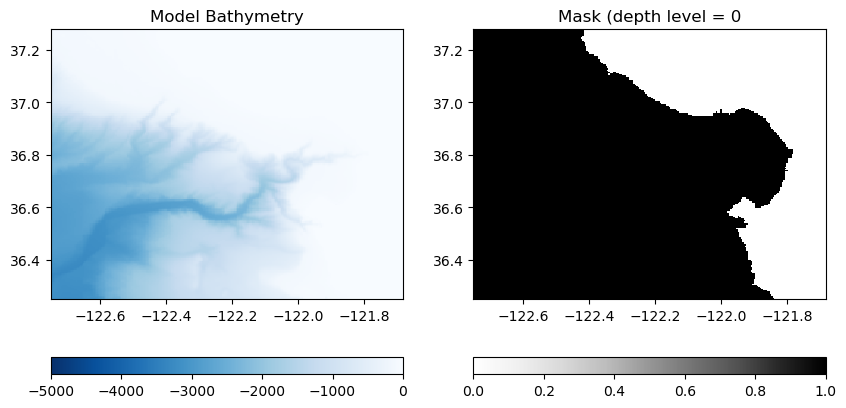

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [10]:
#variable_names = list(file_prefix_dict.keys())

In [11]:
# # make a list to hold all of the ECCO grids
init_grids = []

THETA_unraveled = np.zeros((len(delR),np.size(ecco_XC)))
SALT_unraveled = np.zeros((len(delR), np.size(ecco_XC)))
mask_unraveled = np.zeros((len(delR),np.size(ecco_XC)))

for k in range(len(delR)):
    THETA_unraveled[k,:] = THETA[k,:,:].ravel()
    SALT_unraveled[k, :] = SALT[k, :, :].ravel()
    mask_unraveled[k,:] = HFACC[k,:,:].ravel()
    
init_grids.append(THETA_unraveled)
init_grids.append(SALT_unraveled)
mask_unraveled = mask_unraveled>0

Now, read the initial condition fields from the same tiles:

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [12]:
from eccoseas.downscale import horizontal

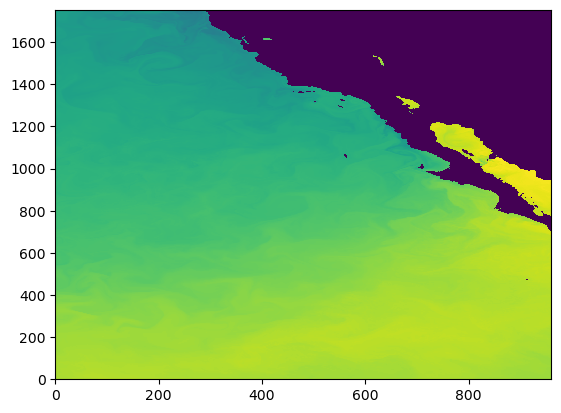

In [13]:
plt.pcolormesh(THETA[0,:,:])

In [14]:
variable_names=['THETA','SALT']

In [15]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):
    print(variable_name, init_grid.shape)
    # print a message to keep track of which variable we are working on
    # uncomment to use
    print('    - Interpolating the '+variable_name+' grid')

    points=np.column_stack([ecco_XC.ravel(),ecco_YC.ravel()])
    print(np.shape(points))
    print(np.shape(init_grid),np.shape(mask_unraveled),np.shape(XC),np.shape(YC),np.shape(mask))
    interpolated_grid = horizontal.downscale_3D_points(points,init_grid, mask_unraveled, XC,YC,mask,testing=True)
    # 1683840
    # XC: 960 x 1754
    # Theta: 90 x 960 x 1754
    # init_grid: 90x1683840                                            
    # output the interpolated grid
    output_file = os.path.join(input_dir,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

THETA (88, 1683840)
    - Interpolating the THETA grid
(1683840, 2)
(88, 1683840) (88, 1683840) (360, 240) (360, 240) (88, 360, 240)
SALT (88, 1683840)
    - Interpolating the SALT grid
(1683840, 2)
(88, 1683840) (88, 1683840) (360, 240) (360, 240) (88, 360, 240)


In [16]:
print(np.shape(SALT))
print(np.shape(THETA))

(88, 1754, 960)
(88, 1754, 960)


### Step 6: Plotting the Initial Condition Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [25]:
meta_dict = {'ETAN':[0.08, 0.13, 'viridis', 'm'],
            'THETA':[15, 18, 'turbo', 'm'],
            'SALT':[33, 34, 'viridis', 'm'],
            'UVEL':[-0.2, 0.2, 'seismic', 'm'],
            'VVEL':[-0.2, 0.2, 'seismic', 'm']}

Then, I'll create all of the subplots:

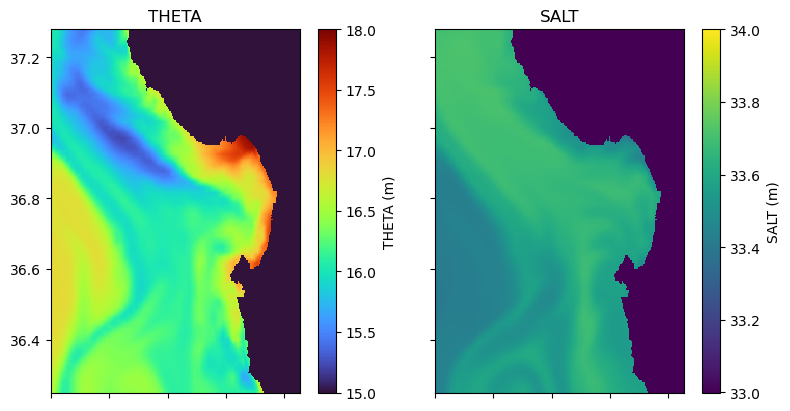

In [26]:
fig = plt.figure(figsize=(12,8))


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')

    if variable_name == 'ETAN':
        CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        CA_init_grid = CA_init_grid[0, :, :] # choose just the surface for plotting
    
    plt.subplot(2,3,i+1)
    C = plt.pcolormesh(XC, YC, CA_init_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')
    plt.title(variable_name)

plt.tight_layout()

plt.show()

Looks good! Now we need to make our external forcing and boundary conditions before we're ready to run the model.

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogThetaFile = 'THETA_IC.bin',
hydrogSaltFile = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```